<img src="https://s3-ap-southeast-1.amazonaws.com/he-public-data/wordmark_black65ee464.png" width="700">

# Classical Support Vector Machines

This notebook will serve as a summary of some of the resources below and is not meant to be used as a stand-alone reading material for Classical Support Vector Machines. We encourage you to complete reading the resources below before going forward with the notebook. 

### Resources: 
1. MIT Open Courseware lecture: https://youtu.be/_PwhiWxHK8o 
3. MIT lecture slides: http://web.mit.edu/6.034/wwwbob/svm-notes-long-08.pdf
4. SVM Wikipedia page : https://en.wikipedia.org/wiki/Support_vector_machine
2. SVM tutorial using sklearn: https://jakevdp.github.io/PythonDataScienceHandbook/05.07-support-vector-machines.html

## Contents

1. [Introduction](#intro)    
2. [SVMs as Linear Classifiers](#linear)
3. [Lagrange Multipliers and the Primal and Dual form](#primal) 
4. [Class Prediction For a New Datapoint](#pred)
5. [Classifying Linearly Separable Data](#class-linear)
6. [Dealing With Non-Linearly Separable Data](#non-linear)
7. [Feature Map and Kernel](#kernel)
8. [Additional Resources](#add)

## Introduction <a id="intro"></a>

In [1]:
# installing a few dependencies
!pip install --upgrade seaborn==0.10.1
!pip install --upgrade scipy==1.4.1
!pip install --upgrade scikit-learn==0.23.1
!pip install --upgrade matplotlib==3.2.0

# the output will be cleared after installation
from IPython.display import clear_output
clear_output()

Suppose you are a Botanist trying to distinguish which one of the **three species** a flower belongs to just by looking at **four features** of a flower - the length and the width of the sepals and petals. As part of your research you create a **dataset** of these features for a set of flowers for which the **species is already known**, where each **datapoint** of this dataset corresponds to a single flower. Now, your colleague brings in a new flower and asks you which species it belongs to. You could go into the lab and do the necessary tests to figure out what species it is, however, the lab is under renovation. So, left with no other choice you pull up the dataset that you created earlier and after a few minutes of trying to find a pattern you realise that this new flower has a petal width and sepal length similar to all the flowers of species 1. Thus, you **predict** this new flower to be of the species 1. This process of assigning a new datapoint to one of the known **classes** (flower species) is called **classfication**. And, as we used a dataset where we knew the classes corresponding to the datapoints before-hand, thus, this classification procedure comes under the umbrella of [**supervised learning**](https://en.wikipedia.org/wiki/Supervised_learning). 


Support Vector Machines (SVMs) are **supervised learning models** that are mainly used for **classification** and **regression** tasks. In the context of classification, which is the topic of discussion, we use SVMs to find a **linear decision boundary with maximum width** splitting the space such that datapoints belonging to different classes are on either side of the boundary. Classification takes place based on which side of the decision boundary a new datapoint lands.  


Before we try to understand how SVMs work, let's take a look at the [Iris dataset](https://en.wikipedia.org/wiki/Iris_flower_data_set) which was the dataset mentioned in the first paragraph.

In [2]:
# importing the iris dataset
from sklearn.datasets import load_iris
import numpy as np

iris = load_iris()

print("Number of datapoints: {}".format(iris['data'].shape[0]))
print("Number of features: {}".format(iris['data'].shape[1]))
print("Sample of the dataset:")
print(iris['data'][:5])
print("Unique species : {}".format(np.unique(iris['target'])))

Number of datapoints: 150
Number of features: 4
Sample of the dataset:
[[5.1 3.5 1.4 0.2]
 [4.9 3.  1.4 0.2]
 [4.7 3.2 1.3 0.2]
 [4.6 3.1 1.5 0.2]
 [5.  3.6 1.4 0.2]]
Unique species : [0 1 2]


Looking at the first 5 datapoints of the Iris dataset we realize that each datapoint is an array with four features. The number of features in a dataset is called the **dimension of the dataset**. Further, there are three unique species, which implies, three **classes** in the dataset. It's important to note that SVMs are natively binary classification algorithms, i.e, can classify between only 2 classes. However, there are methods to convert a binary classifier to a multi-class classifier, mentioned [here](https://datascience.stackexchange.com/questions/46514/how-to-convert-binary-classifier-to-multiclass-classifier). Let us now dig deeper into the mathematics of how SVMs work. 

**Reminder:** Read the resources provided above to understand the next section with greater degree of clarity.

## SVMs as Linear Classifiers <a id="linear"></a>

![title](img/494px-SVM_margin.png)
Source: [wikipedia](https://en.wikipedia.org/wiki/Support_vector_machine)

Our input dataset is of the form $(\vec{x}_{1}, y_{1}), ..., (\vec{x}_{n}, y_{n})$, 
where, $\vec{x}$ is a $d$ dimensional vector where $d$ is the number of features and $y_{i}$'s are the labels $ y_{i} \in {-1, +1}$ as it is a binary classification problem.

$\vec{w}$ is a vector perpendicular to the **decision boundary** (hyperplane that cuts the space into two parts and is the result of classification). Let $\vec{u}$ be a vector representing a point on our feature space. Now, to understand whether a point is on the +ve side or the -ve side we'll have to project the point $\vec{u}$ onto $\vec{w}$, which will give us a scaled version of $\vec{u}$'s projection in the direction perpendicular to the decision boundary. Depending on the value of this quantity we'll have the point either on the +ve side or the -ve side. This can be represented mathematically as


$$\begin{equation} \vec{w}\cdot\vec{x}_{+} + b \geq 1 \label{eq:vector_ray} \tag{1}\end{equation}$$ 
$$\begin{equation} \vec{w}\cdot\vec{x}_{-} + b \leq -1  \tag{2}\end{equation}$$ 

where, $\vec{x}_{+}$ is a datapoint with label $y_{i} = +1$,<br>
$\vec{x}_{-}$ is a datapoint with label $y_{i} = -1$ and<br>
      b is parameter that has to be learnt

These two lines are separated by a distance of $\frac{2}{||{\vec{w}}||}$. The line in the middle of both of these, i.e, 

$$\begin{equation} \vec{w}\cdot\vec{u} + b = 0  \tag{3}\end{equation}$$ 

is the equation of the hyperplane denoting our decision boundary. Together, the space between (1) and (2) forms what is usually know as the **street** or the **gutter**.

equation (1) and (2) can be conveniently combined to give

$$y_{i}(\vec{w}\cdot\vec{x}_{i} + b) \geq 1\tag{4}$$

And the limiting case would be 

$$y_{i}(\vec{w}\cdot\vec{x}_{i} + b) -1 = 0 \tag{5}$$

Which is attained when the points lie on the edges of the street, i.e, on (1) or (2). These points are responsible for the change in the width of the street and are called **support vectors**. Once the support vectors are calculated in the training phase we only need these vectors to classify new datapoints during the prediction phase, hence reducing the computational load significantly. Equation (4) is a constraint in the optimization process of maximizing the street width $\frac{2}{||{\vec{w}}||}$. In the next section let us see how we can combine the optimization problem and the constraints together into a single optimization equation using the concept of  lagrange multipliers.

## Lagrange Multipliers and the Primal and Dual form <a id="primal"></a>

Support Vector Machines are trying to solve the optimization problem of maximizing the street width $\frac{2}{||{\vec{w}}||}$ (which is equivalent to minimizing $\frac{||w||^2}{2}$) with the contraint $y_{i}(\vec{w}\cdot\vec{x}_{i} + b) \geq 1$. This can be elegantly written in a single equation with the help of [lagrange multipliers](https://en.wikipedia.org/wiki/Lagrange_multiplier). The resulting equation to be minimized is called the **primal form** (6).

**Primal form:** $$ L_{p} = \frac{||w||^2}{2} - \sum_{i}{\alpha_{i}[y_{i}(\vec{w}\cdot\vec{x}_{i} + b) -1]}\tag{6}$$

$$\frac{{\partial L}}{\partial \vec{w}} = \vec{w} - \sum_{i}{\alpha_{i}y_{i}\vec{x_{i}}}$$

equating $\frac{{\partial L}}{\partial \vec{w}}$ to 0 we get, 

$$ \vec{w} = \sum_{i}{\alpha_{i}y_{i}\vec{x_{i}}}\tag{7}$$

$$\frac{{\partial L}}{\partial \vec{b}} = \sum_{i}{\alpha_{i}y_{i}}$$

and equating $\frac{{\partial L}}{\partial \vec{b}}$ to 0 we convert the primal form to the dual form, 

$$\sum_{i}{\alpha_{i}y_{i}} = 0\tag{8}$$

$$L = \frac{1}{2}(\sum_{i}{\alpha_{i}y_{i}\vec{x_{i}}})(\sum_{j}{\alpha_{j}y_{j}\vec{x_{j}}}) - (\sum_{i}{\alpha_{i}y_{i}\vec{x_{i}}})(\sum_{j}{\alpha_{j}y_{j}\vec{x_{j}}}) - \sum_{i}{\alpha_{i}y_{i}b} + \sum_{i}{\alpha_{i}}$$

**Dual form:** $$L_{d} = \sum_{i}{\alpha_{i}} - \frac{1}{2}\sum_{i}\sum_{j}\alpha_{i}\alpha_{j}y_{i}y_{j}(\vec{x}_{i}\cdot\vec{x}_{j})\tag{9}$$
subject to: $$\sum_{i}{\alpha_{i}y_{i}} = 0$$

Taking a closer look at the dual form $L_{d}$ we can see that it is a function quadratic in the lagrange multipler terms which can be solved efficiently on a classical computer using [quadratic programming](https://en.wikipedia.org/wiki/Quadratic_programming) techniques. However, Note that finding the dot product $\vec{x}_{i}\cdot\vec{x}_{j}$ becomes computationally expensive as the dimension of our data increases. In the days to come we'll learn how a quantum computer could be used to classify a classical dataset using an algorithm called the Variational Quantum Classifier (VQC) Algorithm as given in [this paper](https://arxiv.org/abs/1804.11326). Understanding of Classical SVM may not be required, however, some of the concepts such as kernels and feature maps will be crucial in understanding the VQC algorithm. 

## Class Prediction for a New Datapoint <a id="pred"></a>

The output of the training step are values of lagrange multipliers. Now, when a new datapoint $\vec z$ is given lets see how we can find the classification result corresponding to it: 

* Step 1: Use the obtained values of lagrange multipliers to calculate the value of $\vec{w}$ using $(7)$.
* Step 2: Substitute the value of $\vec{w}$ in equation $(5)$ and substitute a support vector in the place of $\vec{x}_{i}$ to find the value of $b$.
* Step 3: Find the value of $\vec{w}\cdot\vec{z} + b$. If it $>0$ then assign $\vec{z}$ a label $y_{z} = 1$ and $y_{z} = -1$ if the obtained value is $< 0$.

## Classifying Linearly Separable Data <a id="class-linear"></a>

Lets switch gears and look at how we can use scikit-learn's Support Vector Classifier method to draw a decision boundary on a linearly separable dataset. This section of the notebook is a recap of resource \[4\] and thus we recommend reading it before going forward. The code used in this section is from the corresponding Github [repo](https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/05.07-Support-Vector-Machines.ipynb).

In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# use seaborn plotting defaults
import seaborn as sns; sns.set()

### Importing the dataset

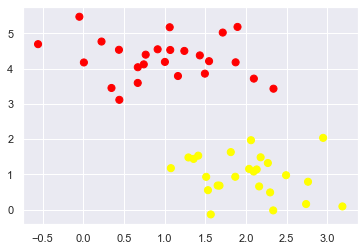

In [4]:
# we are importing the make_blobs dataset as it can be clearly seen to be linearly separable
from sklearn.datasets.samples_generator import make_blobs
X, y = make_blobs(n_samples=50, centers=2,
                  random_state=0, cluster_std=0.60)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn');

In [5]:
from sklearn.svm import SVC # "Support vector classifier"
model = SVC(kernel='linear', C=1E10)
model.fit(X, y)

SVC(C=10000000000.0, kernel='linear')

In [6]:
# helper plotting function
def plot_svc_decision_function(model, ax=None, plot_support=True):
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    # plot decision boundary and margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    
    # plot support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=300, linewidth=1, facecolors='none', edgecolors='b');
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

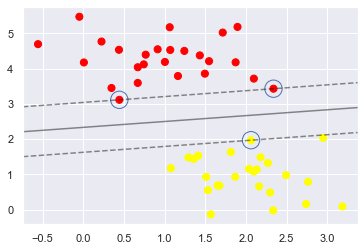

In [7]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(model);

As we can see SVM works quite well when it deals with linearly separable datasets. The points which lie on the dotted lines denoted by $y_{i}(\vec{w}\cdot\vec{x}_{i} + b) = \pm1$ are the **support vectors**. Part of the reason why SVMs are popular are because, during the classification step only support vectors are used to classify a new point. This reduces the computational load significantly. The reason for this is because values of the lagrange multipliers turn out to be zero for vectors which are not support vectors. 

In [8]:
model.support_vectors_

array([[0.44359863, 3.11530945],
       [2.33812285, 3.43116792],
       [2.06156753, 1.96918596]])

## Dealing With Non-Linearly Separable Data <a id="non-linear"></a>

In the previous example we've seen how we can find a model to classify linearly separable data. Lets look at an example and see if SVMs can find a solution when the data is non-linear.

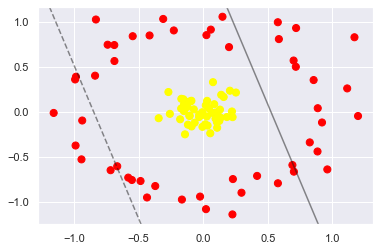

In [9]:
from sklearn.datasets.samples_generator import make_circles
X, y = make_circles(100, factor=.1, noise=.1)

clf = SVC(kernel='linear').fit(X, y)

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(clf, plot_support=False);

When the data is circular, like in the example above, SVM fails to find a satisfactory linear classification model. However, if we cleverly introduce a new parameter $r$ such that $r = e^{-x^{2}}$ and using that as our third parameter construct a new dataset (see picture below), we'll observe that a plane can be drawn horizontally passing through, say, $r=0.7$ to classify the dataset! This method in which we are mapping our dataset into a higher dimension to be able to find a linear boundary in the higher dimension is called a **feature map**. 

In [10]:
r = np.exp(-(X ** 2).sum(1))

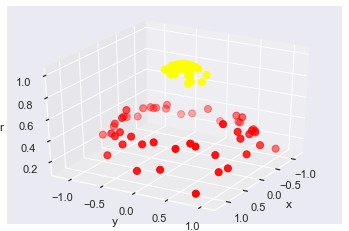

In [11]:
from mpl_toolkits import mplot3d
# from ipywidgets import interact, fixed

def plot_3D(elev=30, azim=30, X=X, y=y):
    ax = plt.subplot(projection='3d')
    ax.scatter3D(X[:, 0], X[:, 1], r, c=y, s=50, cmap='autumn')
    ax.view_init(elev=elev, azim=azim)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('r')

plot_3D()
# interact(plot_3D, elev=[-90, 90], azip=(-180, 180),
#          X=fixed(X), y=fixed(y));

## Feature Map and Kernel <a id="kernel"></a>

As we have seen earlier a **feature map** maps our (non-linearly separable) input data to a higher dimensional  **feature space** where our data is now linearly separable. This helps circumvent the problem of dealing with non-linearly separable data, however, a new problem arises. As we keep increasing the dimension of our data, computing the coordinates of our data and the dot product $\phi(\vec{x}_{i})\cdot\phi(\vec{x}_{j})$ in this higher dimentional feature space becomes computationally expensive. This is where the idea of the [Kernel functions](https://en.wikipedia.org/wiki/Kernel_method) comes in. 

Kernel functions allow us to deal with our data in the higher dimensional feature space (where our data is linearly separable) without ever having to compute the dot product in that space. 

if $\phi(\vec{x})$ is the feature map, then the corresponding kernel function is the dot product $\phi(\vec{x}_{i})\cdot\phi(\vec{x}_{j})$, therefore, the kernel function $k$ is 

$$k(x_{i},x_{j}) = \phi(\vec{x}_{i})\cdot\phi(\vec{x}_{j})$$

Therefore, the corresponding transformed optimization problem can we written as, 

**Primal form:** $$ L_{p} = \frac{||w||^2}{2} - \sum_{i}{\alpha_{i}[y_{i}(\vec{w}\cdot\phi(\vec{x}_{i}) + b) -1]}\tag{6}$$

**Dual form:** $$L_{d} = \sum_{i}{\alpha_{i}} - \frac{1}{2}\sum_{i}\sum_{j}\alpha_{i}\alpha_{j}y_{i}y_{j}(\phi(\vec{x}_{i})\cdot\phi(\vec{x}_{j}))$$
or $$L_{d} = \sum_{i}{\alpha_{i}} - \frac{1}{2}\sum_{i}\sum_{j}\alpha_{i}\alpha_{j}y_{i}y_{j}k(x_{i},x_{j})$$
subject to: $$\sum_{i}{\alpha_{i}y_{i}} = 0$$
where $$ \vec{w} = \sum_{i}{\alpha_{i}y_{i}\phi(\vec{x_{i}})}$$

To understand why Kernel functions are useful lets look at an example using the Radial Basis Function (rbf) Kernel. 

the rbf kernel is written as, 

$$k(x_{i},x_{j}) = exp(-||x_{i} - x_{j}||^{2}/2\sigma^{2}) $$

where $\sigma$ is a tunable parameter 

What we should understand here is that the rbf kernel projects our data into an infinite dimensional feature space, however, the computational power required to compute the kernel function's value is quite negligible! As you see, we don't have to compute the dot product of the infinite dimensional vectors. This is how kernels help SVMs tackle non-linearly separable data. 

Rbf kernel in action:

In [12]:
clf = SVC(kernel='rbf', C=1E6)
clf.fit(X, y) 

SVC(C=1000000.0)

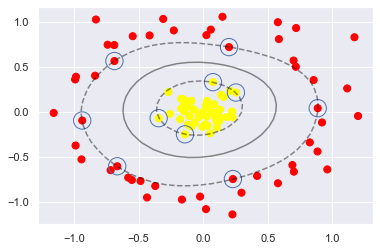

In [13]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(clf)
plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
            s=300, lw=1, facecolors='none');

In the next notebook we will learn how to use Quantum Computers to do the same task of classification and why it may be advantageous in the future. 

## Additional Resources <a id="add"></a>

1. Andrew NG notes: http://cs229.stanford.edu/notes/cs229-notes3.pdf
2. Andrew NG lecture: https://youtu.be/lDwow4aOrtg